In [1]:
import os
import glob
import numpy as np
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
import matplotlib.pyplot as plt
import kagglehub
from torchvision import models
from torchinfo import summary
from torchvision.utils import save_image
from PIL import ImageFilter
from torch.optim.lr_scheduler import CyclicLR,ReduceLROnPlateau
import json
import csv
from pathlib import Path
from typing import Dict, List
from CNNVAE import CNNVAE
from ResNet34 import ResNetTrainer
from VAE import VAE

from GAN import GAN
from CNNGAN import CNNGAN

In [2]:
# Parametry modelu
IMG_SIZE = 128
CHANNELS = 3
LATENT_DIM = 64
HIDDEN_DIM = 512
BATCH_SIZE = 16
EPOCHS = 100
PATIENCE = 1000  # Liczba epok bez poprawy, po których trening się zatrzyma
# Konfiguracja
result_dir = 'results/'
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

result_dir = 'results/GAN'
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

result_dir = 'results/CNNGAN'
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

result_dir = 'results/VAE'
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

result_dir = 'results/CNNVAE'
if not os.path.exists(result_dir):
    os.makedirs(result_dir)


name = 'cnnvae'
device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()
    else torch.device("cpu")
)

if torch.backends.mps.is_available():
    torch.mps.empty_cache()

print(f"Training device: {device}")

Training device: cuda


# Dataset

In [3]:
%pip install torch==2.2.2+cu121 torchvision==0.17.2+cu121 --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
     ---------------------------------------- 0.0/2.5 GB ? eta -:--:--
     ---------------------------------------- 0.0/2.5 GB 21.6 MB/s eta 0:01:54
     ---------------------------------------- 0.0/2.5 GB 35.2 MB/s eta 0:01:10
     ---------------------------------------- 0.0/2.5 GB 44.4 MB/s eta 0:00:55
      --------------------------------------- 0.0/2.5 GB 46.4 MB/s eta 0:00:53
      --------------------------------------- 0.0/2.5 GB 48.4 MB/s eta 0:00:50
      --------------------------------------- 0.1/2.5 GB 49.7 MB/s eta 0:00:49
     - -------------------------------------- 0.1/2.5 GB 50.3 MB/s eta 0:00:48
     - -------------------------------------- 0.1/2.5 GB 50.7 MB/s eta 0:00:47
     - -------------------------------------- 0.1/2.5 GB 51.2 MB/s eta 0:00:47
     - -------------------------------------- 0.1/2.5 GB 51.2 MB/s eta 0:00:46
     - -------------------------------------- 0.1/2.5 GB 51.2 MB/s eta 0:00:46
 

  You can safely remove it manually.
  You can safely remove it manually.

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


(128, 128, 3)


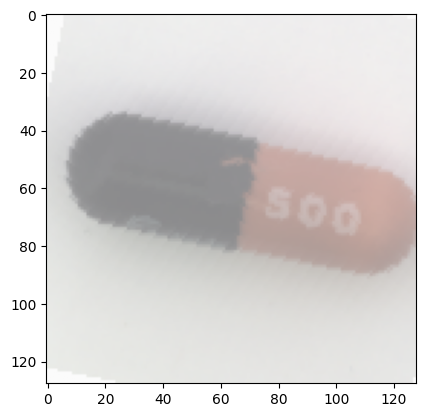

In [3]:
class CapsuleNegativeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = glob.glob(os.path.join(root_dir, '*'))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image
    
if CHANNELS==3:
    normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
else:
    normalize = transforms.Normalize(mean=[0.5], std=[0.5])


transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomAffine(degrees=15, translate=(0.05, 0.05), scale=(1.1, 1.15),fill=255),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

# Ścieżka do danych 

path = kagglehub.dataset_download("tladilebohang/capsule-defects")

dataset = CapsuleNegativeDataset(
    root_dir=os.path.join(path, 'capsule/negative'),
    transform=transform
)

# Podział danych
full_indices = np.arange(len(dataset))
train_val_indices, test_indices = train_test_split(
    full_indices, test_size=0.2, random_state=42, shuffle=True
)
train_indices, val_indices = train_test_split(
    train_val_indices, test_size=0.2, random_state=42, shuffle=True
)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


#Print first image
data_iter = iter(train_loader)
images = next(data_iter)  # 

image = images[0]

image = (image+1)/2

image = image.permute(1, 2, 0).numpy()
image = np.array(image)
print(image.shape)

plt.imshow(image)


In [4]:
class GANLogger:
    def __init__(self, save_dir: str, filename: str = "history"):
        self.save_dir = Path(save_dir)
        self.save_dir.mkdir(parents=True, exist_ok=True)
        self.filename = filename
        # Initialize empty history
        self.history: Dict[str, List[float]] = {
            "epoch": [],
            "gen_loss": [],
            "disc_loss": [],
            "val_loss": [],
        }

    def log(self, epoch: int, gen_loss: float, disc_loss: float, val_loss: float):
        """Append one epoch’s metrics."""
        self.history["epoch"].append(epoch)
        self.history["gen_loss"].append(gen_loss)
        self.history["disc_loss"].append(disc_loss)
        self.history["val_loss"].append(val_loss)

    def save_json(self):
        """Dump the history to a JSON file."""
        json_path = self.save_dir / f"{self.filename}.json"
        with open(json_path, "w") as f:
            json.dump(self.history, f, indent=2)

In [5]:
class VAELogger:
    def __init__(self, save_dir: str, filename: str = "history"):
        self.save_dir = Path(save_dir)
        self.save_dir.mkdir(parents=True, exist_ok=True)
        self.filename = filename
        # Initialize empty history
        self.history: Dict[str, List[float]] = {
            "epoch": [],
            "train_loss": [],
            "validation_loss": [],
        }

    def log(self, epoch: int, train_loss: float, val_loss: float):
        """Append one epoch’s metrics."""
        self.history["epoch"].append(epoch)
        self.history["train_loss"].append(train_loss)
        self.history["validation_loss"].append(val_loss)

    def save_json(self):
        """Dump the history to a JSON file."""
        json_path = self.save_dir / f"{self.filename}.json"
        with open(json_path, "w") as f:
            json.dump(self.history, f, indent=2)

# VAE

In [6]:
BCE_loss = nn.BCELoss(reduction='sum')
MSE_loss = nn.MSELoss(reduction='sum')


# Funkcja strat z modelem, ktory porownuje ekstaktowane cechy 
def CNN_loss(self,recon_x, x, mu, logvar, perceptual_loss):
    # Perceptual Loss dla cech
    percep_loss = perceptual_loss(recon_x, x)

    # Standardowa strata VAE (BCE + KLD)
    bce = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Ważone sumowanie (można dostosować wagi)
    return 0.7 * percep_loss + 0.3 * bce + 0.1* kld


#Do testowania
def loss_tmp(recon_x, x, mu, logvar):
    MSE=0
    BCE=0
    # BCE = F.binary_cross_entropy(recon_x, x,reduction='sum')
    # BCE = F.mse_loss(recon_x, x, size_average=False)
    #recon_x_normalized = (recon_x + 1) / 2  # Przeskalowanie z [-1, 1] na [0, 1]
    #x_normalized = (x + 1) / 2
    BCE = BCE_loss(recon_x, x)/x.size(0)
    #MSE = MSE_loss(recon_x, x)/x.size(0)
    
    #MSE=MSE/x.size(0)
    

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    

    return BCE + MSE + KLD




def loss_from_article(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD



In [7]:
# Inicjalizacja

model = VAE(device=device,result_dir='results/VAE',load_pretrained=True).to(device)

#model = CNNVAE(device=device,result_dir='results/CNNVAE',load_pretrained=True).to(device)


if isinstance(model,CNNVAE):
    result_dir = 'results/CNNVAE'
    name = 'cnnvae'


if isinstance(model,VAE):
    result_dir = 'results/VAE'
    name = 'vae'

dummy_input = torch.zeros(1, CHANNELS, IMG_SIZE, IMG_SIZE).to(device)  
summary(model, input_data=dummy_input)

[INFO] No VAE checkpoint found.


Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [1, 3, 128, 128]          --
├─Sequential: 1-1                        [1, 256]                  --
│    └─Linear: 2-1                       [1, 512]                  25,166,336
│    └─ReLU: 2-2                         [1, 512]                  --
│    └─Dropout: 2-3                      [1, 512]                  --
│    └─Linear: 2-4                       [1, 358]                  183,654
│    └─ReLU: 2-5                         [1, 358]                  --
│    └─Dropout: 2-6                      [1, 358]                  --
│    └─Linear: 2-7                       [1, 256]                  91,904
│    └─ReLU: 2-8                         [1, 256]                  --
├─Linear: 1-2                            [1, 64]                   16,448
├─Linear: 1-3                            [1, 64]                   16,448
├─Sequential: 1-4                        [1, 49152]         

# Pętla treningowa VAE

In [8]:
# Główna pętla
best_loss = float('inf')
no_improve = 0  # Licznik epok bez poprawy

logger = VAELogger(save_dir="results/VAE", filename="vae_metrics")

for epoch in range(1, EPOCHS + 1):
    train_loss=model.train_vae(epoch=epoch,dataloader=train_loader,loss_fn=loss_tmp)
    validate_loss = model.validate(epoch=epoch,dataloader=train_loader,loss_fn=loss_tmp)
    
    logger.log(epoch, train_loss, validate_loss)
    
    # Zapisywanie najlepszego modelu
    if train_loss < best_loss:
        best_loss = train_loss
        model.visualize_reconstruction(epoch=epoch,dataloader=train_loader)
        torch.save(model.state_dict(), f'{result_dir}/{name}_best.pth')
        no_improve = 0  
    else:
        no_improve += 1

    # Early stopping
    if no_improve >= PATIENCE:
        print(f'\nEarly stopping after {PATIENCE} epochs without improvement')
        break

    print(f'Epoch {epoch}: Train Loss = {train_loss:.4f} (Best: {best_loss:.4f})')
    
logger.save_json()    

Train Epoch: 1 | Loss: 2244.6702
Validate Epoch: 1 | Loss: 1967.4310
Epoch 1: Train Loss = 2244.6702 (Best: 2244.6702)
Train Epoch: 2 | Loss: 1973.8148
Validate Epoch: 2 | Loss: 1935.6707
Epoch 2: Train Loss = 1973.8148 (Best: 1973.8148)
Train Epoch: 3 | Loss: 1925.2640
Validate Epoch: 3 | Loss: 1965.9591
Epoch 3: Train Loss = 1925.2640 (Best: 1925.2640)
Train Epoch: 4 | Loss: 1944.6928
Validate Epoch: 4 | Loss: 2001.7264
Epoch 4: Train Loss = 1944.6928 (Best: 1925.2640)
Train Epoch: 5 | Loss: 1968.3888
Validate Epoch: 5 | Loss: 1861.5697
Epoch 5: Train Loss = 1968.3888 (Best: 1925.2640)
Train Epoch: 6 | Loss: 1900.4682
Validate Epoch: 6 | Loss: 1943.3280
Epoch 6: Train Loss = 1900.4682 (Best: 1900.4682)
Train Epoch: 7 | Loss: 1953.1483
Validate Epoch: 7 | Loss: 1945.0877
Epoch 7: Train Loss = 1953.1483 (Best: 1900.4682)
Train Epoch: 8 | Loss: 1843.3382
Validate Epoch: 8 | Loss: 1885.5591
Epoch 8: Train Loss = 1843.3382 (Best: 1843.3382)
Train Epoch: 9 | Loss: 1921.7343
Validate Epoch:

In [26]:
def save_samples(samples, output_dir=result_dir):
    for i, sample in enumerate(samples):
        # Zapis do pliku PNG
        save_image(sample, os.path.join(output_dir, f"sample_{i}.png"))

In [27]:
# Przykład użycia:
device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()
    else torch.device("cpu")
)
desired_variance = 0.5
desired_mu = 0.3

model = VAE().to(device)
state_dict = torch.load(result_dir+'/cnnvae_best.pth', map_location='cpu')
model.load_state_dict(state_dict)
model.eval()

mu = torch.tensor(desired_mu) * torch.ones(LATENT_DIM).to(device)
logvar = torch.log(torch.tensor(desired_variance)) * torch.ones(LATENT_DIM).to(device)
samples = model.generate_from_accurate_params(mu, logvar, num_samples=5, device=device)

save_samples(samples)

[INFO] No VAE checkpoint found.


RuntimeError: Error(s) in loading state_dict for VAE:
	Missing key(s) in state_dict: "encoder.0.weight", "encoder.0.bias", "encoder.3.weight", "encoder.3.bias", "encoder.6.weight", "encoder.6.bias", "decoder.0.weight", "decoder.0.bias", "decoder.2.weight", "decoder.2.bias". 
	Unexpected key(s) in state_dict: "encoder_conv.0.weight", "encoder_conv.0.bias", "encoder_conv.2.weight", "encoder_conv.2.bias", "encoder_conv.4.weight", "encoder_conv.4.bias", "encoder_conv.6.weight", "encoder_conv.6.bias", "encoder_conv.8.weight", "encoder_conv.8.bias", "decoder_fc.0.weight", "decoder_fc.0.bias", "decoder_conv.0.weight", "decoder_conv.0.bias", "decoder_conv.2.weight", "decoder_conv.2.bias", "decoder_conv.4.weight", "decoder_conv.4.bias", "decoder_conv.6.weight", "decoder_conv.6.bias", "decoder_conv.8.weight", "decoder_conv.8.bias". 
	size mismatch for fc_mu.weight: copying a param with shape torch.Size([256, 8192]) from checkpoint, the shape in current model is torch.Size([64, 256]).
	size mismatch for fc_mu.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fc_var.weight: copying a param with shape torch.Size([256, 8192]) from checkpoint, the shape in current model is torch.Size([64, 256]).
	size mismatch for fc_var.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).

In [ ]:
# Przykład użycia:
device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()
    else torch.device("cpu")
)


model= VAE().to(device)
state_dict = torch.load(result_dir+'vae_best.pth', map_location='cpu')
model.load_state_dict(state_dict)
model.eval()

data = next(iter(test_loader)).to(device)
tmp_image = data[0]  # Zakładając, że data[0] to obrazy z batcha

# Dodaj wymiar batcha, jeśli obraz jest pojedynczy
tmp_image = tmp_image.unsqueeze(0)  # Dodaje wymiar batcha na początku



# Upewnij się, że obraz jest na odpowiednim urządzeniu
tmp_image = tmp_image.to(device)

# Przekazujemy obraz do modelu
recon, mu, logvar = model(tmp_image)

samples = model.generate_from_accurate_params(mu, logvar, num_samples=5, device=device)

save_samples(samples)

# GAN/DCGAN


In [7]:


gan=GAN(IMG_SIZE,CHANNELS,LATENT_DIM,device,result_dir="results/GAN",load_pretrained=True)

#gan=CNNGAN(IMG_SIZE,CHANNELS,LATENT_DIM,device,result_dir="results/CNNGAN",load_pretrained=True)


[INFO] No generator checkpoint found.
[INFO] No discriminator checkpoint found.


# Pętla główna treningu GAN/CNNGAN

In [8]:
best_g_loss = float('inf')
best_d_loss = float('inf')
no_improve = 0  # Licznik epok bez poprawy

logger = GANLogger(save_dir="results/GAN", filename="gan_metrics")

for epoch in range(1, EPOCHS + 1):
    
    g_loss, d_loss = gan.train_gan(epoch, dataloader=train_loader)

    # Walidacja
    validate_loss = gan.validate(epoch, val_loader)

    # Wizualizacja rekonstrukcji
    gan.visualize_reconstruction(epoch)

    logger.log(epoch, g_loss, d_loss, validate_loss)

    if g_loss < best_g_loss:
        best_g_loss = g_loss
        gan.save_generator()
        no_improve = 0
    else:
        no_improve += 1

    if d_loss < best_d_loss:
        best_d_loss = d_loss
        gan.save_discriminator()
        no_improve = 0
    else:
        no_improve += 1

    # Early stopping
    if no_improve >= PATIENCE:
        print(f'\nEarly stopping after {PATIENCE} epochs without improvement')
        break

    print(f'Epoch {epoch}: Validation Loss = {validate_loss:.4f} Generator Loss = {g_loss:.4f}, Discriminator Loss = {d_loss:.4f} \n (Best G: {best_g_loss:.4f} Best D: {best_d_loss:.4f}) ')

logger.save_json()

Epoch 1: Generator Loss = 9.7600, Discriminator Loss = 6.0208
Epoch 1: Validation Loss = 2.9360
Epoch 1: Validation Loss = 2.9360 Generator Loss = 9.7600, Discriminator Loss = 6.0208 
 (Best G: 9.7600 Best D: 6.0208) 
Epoch 2: Generator Loss = 10.8798, Discriminator Loss = 4.6944
Epoch 2: Validation Loss = 3.9196
Epoch 2: Validation Loss = 3.9196 Generator Loss = 10.8798, Discriminator Loss = 4.6944 
 (Best G: 9.7600 Best D: 4.6944) 
Epoch 3: Generator Loss = 6.0911, Discriminator Loss = 7.9562
Epoch 3: Validation Loss = 4.2210
Epoch 3: Validation Loss = 4.2210 Generator Loss = 6.0911, Discriminator Loss = 7.9562 
 (Best G: 6.0911 Best D: 4.6944) 
Epoch 4: Generator Loss = 8.4777, Discriminator Loss = 6.2495
Epoch 4: Validation Loss = 3.9419
Epoch 4: Validation Loss = 3.9419 Generator Loss = 8.4777, Discriminator Loss = 6.2495 
 (Best G: 6.0911 Best D: 4.6944) 
Epoch 5: Generator Loss = 6.8712, Discriminator Loss = 7.2053
Epoch 5: Validation Loss = 6.1037
Epoch 5: Validation Loss = 6.1

# Generating New Data for each method

In [4]:
gan = GAN(IMG_SIZE,CHANNELS,LATENT_DIM,device,result_dir="results/GAN",load_pretrained=True)
cnngan = CNNGAN(IMG_SIZE,CHANNELS,LATENT_DIM,device,result_dir="results/CNNGAN",load_pretrained=True)
vae = VAE(device=device,result_dir='results/VAE',load_pretrained=True).to(device)
cnnvae = CNNVAE(device=device,result_dir='results/CNNVAE',load_pretrained=True).to(device)



# gan.generate_new_data(num_samples=300)
# cnngan.generate_new_data(num_samples=300)

vae.generate_similar_data(dataset, num_samples=100)
cnnvae.generate_similar_data(dataset, num_samples=100)


[INFO] Loaded best generator weights.
[INFO] Loaded best discriminator weights.
[INFO] Loaded best generator weights.
[INFO] Loaded best discriminator weights.
[INFO] Loaded best VAE weights.
[INFO] Loaded best VAE weights.


# Classification

In [4]:
dirs_to_create = [
    'res_net_model/',
    'res_net_model/original_dataset/',
    'res_net_model/oversampled_dataset/',
    'res_net_model/oversampled_dataset/CNNGAN/',
    'res_net_model/oversampled_dataset/GAN/',
    'res_net_model/oversampled_dataset/CNNVAE/',
    'res_net_model/oversampled_dataset/VAE/',
    'res_net_model/oversampled_dataset/',
    'res_net_model/synthetic_dataset/CNNGAN/',
    'res_net_model/synthetic_dataset/GAN/',
    'res_net_model/synthetic_dataset/CNNVAE/',
    'res_net_model/synthetic_dataset/VAE/',
    'res_net_model/over_oversampled_dataset/',
    'res_net_model/over_oversampled_dataset/CNNGAN/',
    'res_net_model/over_oversampled_dataset/GAN/',
    'res_net_model/over_oversampled_dataset/CNNVAE/',
    'res_net_model/over_oversampled_dataset/VAE/',
]

for dir_path in dirs_to_create:
    os.makedirs(dir_path, exist_ok=True)
    
rskf = RepeatedStratifiedKFold(
    n_splits=2,
    n_repeats=5,
    random_state=42
)

## Datasets

In [5]:
class CapsuleDataset(Dataset):
    def __init__(self,
                 pos_dir: str,
                 neg_dirs,
                 transform=None,
                 max_per_dir: int = None):
        """
        neg_dirs: either a single path string or a list of paths
        max_per_dir: if set, take at most this many files from EACH directory
        """
        if isinstance(neg_dirs, str):
            neg_dirs = [neg_dirs]

        self.transform = transform
        self.samples = []

        def _gather_files(directory):
            files = sorted(glob.glob(os.path.join(directory, "*")))
            if max_per_dir is not None:
                return files[:max_per_dir]
            return files

        # positives (label=0)
        pos_files = sorted(glob.glob(os.path.join(pos_dir, "*")))
        self.samples += [(p, 0) for p in pos_files]

        # negatives (label=1)
        for nd in neg_dirs:
            neg_files = _gather_files(nd)
            self.samples += [(p, 1) for p in neg_files]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        return img, label

# hyper‑parameters
IMG_SIZE   = 128
BATCH_SIZE = 16
CHANNELS   = 3
EPOCHS = 25
# normalization
if CHANNELS == 3:
    normalize = transforms.Normalize([0.5]*3, [0.5]*3)
else:
    normalize = transforms.Normalize([0.5], [0.5])

# your augmentations + normalization
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomAffine(degrees=15, translate=(0.05,0.05), scale=(1.1,1.15), fill=255),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    normalize
])

path = kagglehub.dataset_download("tladilebohang/capsule-defects")
# download or mount your Kaggle data however you like; suppose:
# path = ".../capsule-defects"
pos_folder = os.path.join(path, "capsule/positive")
neg_folder = os.path.join(path, "capsule/negative")
print(len(glob.glob(os.path.join(pos_folder, "*"))))
print(len(glob.glob(os.path.join(neg_folder, "*"))))

219
109


### Original Dataset

In [6]:
dataset = CapsuleDataset(pos_dir=pos_folder, neg_dirs=neg_folder, transform=transform)
print(dataset.__len__())

328


### Oversampled Dataset (Equality in classes' instances)

#### CNNGAN

In [28]:
sample_folder = 'generated_images/CNNGAN'
dataset = CapsuleDataset(pos_dir=pos_folder, neg_dirs=[neg_folder, sample_folder], max_per_dir=110, transform=transform)

In [ ]:
labels = np.array([dataset[i][1] for i in range(len(dataset))])

all_fold_results = []

for fold_idx, (train_idx, test_idx) in enumerate(rskf.split(X=np.zeros(len(labels)), y=labels), start=1):
    print(f"===== Fold {fold_idx} =====")

    # Subset + DataLoader
    train_ds = Subset(dataset, train_idx)
    test_ds  = Subset(dataset, test_idx)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

    trainer = ResNetTrainer()

    trainer.train(
        train_loader,
        val_loader=test_loader,
        num_epochs=EPOCHS,
        save_best_to=f"res_net_model/oversampled_dataset/CNNGAN/best_fold_{fold_idx}.pth" # UWAGA na path
    )

    trainer.load_model(f"res_net_model/oversampled_dataset/CNNGAN/best_fold_{fold_idx}.pth") # UWAGA na path
    _, acc = trainer.validate(test_loader)
    print(f"Fold {fold_idx} Test Accuracy: {acc:.4f}")

    all_fold_results.append(acc)

mean_acc = np.mean(all_fold_results)
std_acc  = np.std(all_fold_results, ddof=1)
print(f"\n5×2 CV results: Mean Acc = {mean_acc:.4f}, Std Dev = {std_acc:.4f}")

#### GAN

In [7]:
sample_folder = 'generated_images/GAN'
dataset = CapsuleDataset(pos_dir=pos_folder, neg_dirs=[neg_folder, sample_folder], max_per_dir=110, transform=transform)

In [8]:
labels = np.array([dataset[i][1] for i in range(len(dataset))])

all_fold_results = []

for fold_idx, (train_idx, test_idx) in enumerate(rskf.split(X=np.zeros(len(labels)), y=labels), start=1):
    print(f"===== Fold {fold_idx} =====")

    # Subset + DataLoader
    train_ds = Subset(dataset, train_idx)
    test_ds  = Subset(dataset, test_idx)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

    trainer = ResNetTrainer()

    trainer.train(
        train_loader,
        val_loader=test_loader,
        num_epochs=EPOCHS,
        save_best_to=f"res_net_model/oversampled_dataset/GAN/best_fold_{fold_idx}.pth" # UWAGA na path
    )

    trainer.load_model(f"res_net_model/oversampled_dataset/GAN/best_fold_{fold_idx}.pth") # UWAGA na path
    _, acc = trainer.validate(test_loader)
    print(f"Fold {fold_idx} Test Accuracy: {acc:.4f}")

    all_fold_results.append(acc)

mean_acc = np.mean(all_fold_results)
std_acc  = np.std(all_fold_results, ddof=1)
print(f"\n5×2 CV results: Mean Acc = {mean_acc:.4f}, Std Dev = {std_acc:.4f}")

===== Fold 1 =====
Epoch 1/25 | Train Loss: 0.6045 Acc: 0.7123 | Val Loss: 0.5538 Acc: 0.6941
Epoch 2/25 | Train Loss: 0.4889 Acc: 0.7626 | Val Loss: 0.5527 Acc: 0.6667
Epoch 3/25 | Train Loss: 0.4821 Acc: 0.7763 | Val Loss: 0.5211 Acc: 0.7123
Epoch 4/25 | Train Loss: 0.4036 Acc: 0.7854 | Val Loss: 0.5602 Acc: 0.7169
Epoch 5/25 | Train Loss: 0.4133 Acc: 0.7900 | Val Loss: 0.5249 Acc: 0.7260
Epoch 6/25 | Train Loss: 0.4047 Acc: 0.8265 | Val Loss: 0.4695 Acc: 0.7260
Epoch 7/25 | Train Loss: 0.4467 Acc: 0.7991 | Val Loss: 0.6075 Acc: 0.6164
Epoch 8/25 | Train Loss: 0.3359 Acc: 0.8493 | Val Loss: 0.4613 Acc: 0.7763
Epoch 9/25 | Train Loss: 0.3102 Acc: 0.8767 | Val Loss: 0.5540 Acc: 0.7443
Epoch 10/25 | Train Loss: 0.2942 Acc: 0.8539 | Val Loss: 0.4927 Acc: 0.7489
Epoch 11/25 | Train Loss: 0.2722 Acc: 0.8630 | Val Loss: 0.4516 Acc: 0.7763
Epoch 12/25 | Train Loss: 0.3189 Acc: 0.8630 | Val Loss: 0.3970 Acc: 0.7945
Epoch 13/25 | Train Loss: 0.2433 Acc: 0.9132 | Val Loss: 0.4203 Acc: 0.7945
Ep

#### CNNVAE

In [7]:
sample_folder = 'generated_images/CNNVAE'
dataset = CapsuleDataset(pos_dir=pos_folder, neg_dirs=[neg_folder, sample_folder], max_per_dir=110, transform=transform)

In [8]:
labels = np.array([dataset[i][1] for i in range(len(dataset))])

all_fold_results = []

for fold_idx, (train_idx, test_idx) in enumerate(rskf.split(X=np.zeros(len(labels)), y=labels), start=1):
    print(f"===== Fold {fold_idx} =====")

    # Subset + DataLoader
    train_ds = Subset(dataset, train_idx)
    test_ds  = Subset(dataset, test_idx)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

    trainer = ResNetTrainer()

    trainer.train(
        train_loader,
        val_loader=test_loader,
        num_epochs=EPOCHS,
        save_best_to=f"res_net_model/oversampled_dataset/CNNVAE/best_fold_{fold_idx}.pth" # UWAGA na path
    )

    trainer.load_model(f"res_net_model/oversampled_dataset/CNNVAE/best_fold_{fold_idx}.pth") # UWAGA na path
    _, acc = trainer.validate(test_loader)
    print(f"Fold {fold_idx} Test Accuracy: {acc:.4f}")

    all_fold_results.append(acc)

mean_acc = np.mean(all_fold_results)
std_acc  = np.std(all_fold_results, ddof=1)
print(f"\n5×2 CV results: Mean Acc = {mean_acc:.4f}, Std Dev = {std_acc:.4f}")

===== Fold 1 =====
Epoch 1/25 | Train Loss: 0.5752 Acc: 0.7032 | Val Loss: 0.6516 Acc: 0.6758
Epoch 2/25 | Train Loss: 0.3923 Acc: 0.8128 | Val Loss: 0.5846 Acc: 0.6484
Epoch 3/25 | Train Loss: 0.5497 Acc: 0.7717 | Val Loss: 0.9610 Acc: 0.4977
Epoch 4/25 | Train Loss: 0.5461 Acc: 0.7443 | Val Loss: 0.5847 Acc: 0.6301
Epoch 5/25 | Train Loss: 0.4664 Acc: 0.7808 | Val Loss: 0.6255 Acc: 0.5890
Epoch 6/25 | Train Loss: 0.3942 Acc: 0.8174 | Val Loss: 0.5404 Acc: 0.7215
Epoch 7/25 | Train Loss: 0.3537 Acc: 0.8265 | Val Loss: 0.6454 Acc: 0.6347
Epoch 8/25 | Train Loss: 0.3135 Acc: 0.8356 | Val Loss: 0.5049 Acc: 0.6849
Epoch 9/25 | Train Loss: 0.3048 Acc: 0.8584 | Val Loss: 0.5567 Acc: 0.7306
Epoch 10/25 | Train Loss: 0.3468 Acc: 0.8311 | Val Loss: 0.4570 Acc: 0.7489
Epoch 11/25 | Train Loss: 0.3034 Acc: 0.8493 | Val Loss: 0.4533 Acc: 0.7534
Epoch 12/25 | Train Loss: 0.2887 Acc: 0.8950 | Val Loss: 0.4952 Acc: 0.7260
Epoch 13/25 | Train Loss: 0.2772 Acc: 0.8676 | Val Loss: 0.5176 Acc: 0.7306
Ep

#### VAE

In [9]:
sample_folder = 'generated_images/VAE'
dataset = CapsuleDataset(pos_dir=pos_folder, neg_dirs=[neg_folder, sample_folder], max_per_dir=110, transform=transform)

In [10]:
labels = np.array([dataset[i][1] for i in range(len(dataset))])

all_fold_results = []

for fold_idx, (train_idx, test_idx) in enumerate(rskf.split(X=np.zeros(len(labels)), y=labels), start=1):
    print(f"===== Fold {fold_idx} =====")

    # Subset + DataLoader
    train_ds = Subset(dataset, train_idx)
    test_ds  = Subset(dataset, test_idx)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

    trainer = ResNetTrainer()

    trainer.train(
        train_loader,
        val_loader=test_loader,
        num_epochs=EPOCHS,
        save_best_to=f"res_net_model/oversampled_dataset/VAE/best_fold_{fold_idx}.pth" # UWAGA na path
    )

    trainer.load_model(f"res_net_model/oversampled_dataset/VAE/best_fold_{fold_idx}.pth") # UWAGA na path
    _, acc = trainer.validate(test_loader)
    print(f"Fold {fold_idx} Test Accuracy: {acc:.4f}")

    all_fold_results.append(acc)

mean_acc = np.mean(all_fold_results)
std_acc  = np.std(all_fold_results, ddof=1)
print(f"\n5×2 CV results: Mean Acc = {mean_acc:.4f}, Std Dev = {std_acc:.4f}")

===== Fold 1 =====
Epoch 1/25 | Train Loss: 0.6117 Acc: 0.6530 | Val Loss: 0.5974 Acc: 0.6164
Epoch 2/25 | Train Loss: 0.5454 Acc: 0.7489 | Val Loss: 0.6997 Acc: 0.5342
Epoch 3/25 | Train Loss: 0.4794 Acc: 0.7215 | Val Loss: 0.6078 Acc: 0.6347
Epoch 4/25 | Train Loss: 0.4333 Acc: 0.7671 | Val Loss: 0.5612 Acc: 0.6575
Epoch 5/25 | Train Loss: 0.4406 Acc: 0.8174 | Val Loss: 0.6017 Acc: 0.6027
Epoch 6/25 | Train Loss: 0.4265 Acc: 0.7717 | Val Loss: 0.6204 Acc: 0.6164
Epoch 7/25 | Train Loss: 0.4423 Acc: 0.7717 | Val Loss: 0.5847 Acc: 0.7260
Epoch 8/25 | Train Loss: 0.3820 Acc: 0.8037 | Val Loss: 0.5428 Acc: 0.7671
Epoch 9/25 | Train Loss: 0.3939 Acc: 0.7991 | Val Loss: 0.5040 Acc: 0.7215
Epoch 10/25 | Train Loss: 0.3416 Acc: 0.8311 | Val Loss: 0.4876 Acc: 0.7352
Epoch 11/25 | Train Loss: 0.3412 Acc: 0.8356 | Val Loss: 0.4636 Acc: 0.7534
Epoch 12/25 | Train Loss: 0.3279 Acc: 0.8630 | Val Loss: 0.4640 Acc: 0.7443
Epoch 13/25 | Train Loss: 0.3372 Acc: 0.8447 | Val Loss: 0.5210 Acc: 0.7443
Ep

### Syntethic dataset (negative class only made from generated images)

#### CNNGAN

In [13]:
sample_folder = 'generated_images/CNNGAN'
dataset = CapsuleDataset(pos_dir=pos_folder, neg_dirs=[sample_folder], max_per_dir=219, transform=transform)

In [14]:
labels = np.array([dataset[i][1] for i in range(len(dataset))])

all_fold_results = []

for fold_idx, (train_idx, test_idx) in enumerate(rskf.split(X=np.zeros(len(labels)), y=labels), start=1):
    print(f"===== Fold {fold_idx} =====")

    # Subset + DataLoader
    train_ds = Subset(dataset, train_idx)
    test_ds  = Subset(dataset, test_idx)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

    trainer = ResNetTrainer()

    trainer.train(
        train_loader,
        val_loader=test_loader,
        num_epochs=EPOCHS,
        save_best_to=f"res_net_model/synthetic_dataset/CNNGAN/best_fold_{fold_idx}.pth" # UWAGA na path
    )

    trainer.load_model(f"res_net_model/synthetic_dataset/CNNGAN/best_fold_{fold_idx}.pth") # UWAGA na path
    _, acc = trainer.validate(test_loader)
    print(f"Fold {fold_idx} Test Accuracy: {acc:.4f}")

    all_fold_results.append(acc)

mean_acc = np.mean(all_fold_results)
std_acc  = np.std(all_fold_results, ddof=1)
print(f"\n5×2 CV results: Mean Acc = {mean_acc:.4f}, Std Dev = {std_acc:.4f}")

===== Fold 1 =====
Epoch 1/25 | Train Loss: 0.2726 Acc: 0.8767 | Val Loss: 0.0956 Acc: 1.0000
Epoch 2/25 | Train Loss: 0.0280 Acc: 1.0000 | Val Loss: 0.0093 Acc: 1.0000
Epoch 3/25 | Train Loss: 0.0064 Acc: 1.0000 | Val Loss: 0.0031 Acc: 1.0000
Epoch 4/25 | Train Loss: 0.0140 Acc: 0.9954 | Val Loss: 0.0014 Acc: 1.0000
Epoch 5/25 | Train Loss: 0.0061 Acc: 1.0000 | Val Loss: 0.0013 Acc: 1.0000
Epoch 6/25 | Train Loss: 0.0023 Acc: 1.0000 | Val Loss: 0.0010 Acc: 1.0000
Epoch 7/25 | Train Loss: 0.0037 Acc: 1.0000 | Val Loss: 0.0008 Acc: 1.0000
Epoch 8/25 | Train Loss: 0.0014 Acc: 1.0000 | Val Loss: 0.0006 Acc: 1.0000
Epoch 9/25 | Train Loss: 0.0011 Acc: 1.0000 | Val Loss: 0.0008 Acc: 1.0000
Epoch 10/25 | Train Loss: 0.0029 Acc: 1.0000 | Val Loss: 0.0006 Acc: 1.0000
Epoch 11/25 | Train Loss: 0.0019 Acc: 1.0000 | Val Loss: 0.0007 Acc: 1.0000
Epoch 12/25 | Train Loss: 0.0014 Acc: 1.0000 | Val Loss: 0.0007 Acc: 1.0000
Epoch 13/25 | Train Loss: 0.0132 Acc: 1.0000 | Val Loss: 0.0007 Acc: 1.0000
Ep

#### GAN

In [15]:
sample_folder = 'generated_images/GAN'
dataset = CapsuleDataset(pos_dir=pos_folder, neg_dirs=[sample_folder], max_per_dir=219, transform=transform)

In [16]:
labels = np.array([dataset[i][1] for i in range(len(dataset))])

all_fold_results = []

for fold_idx, (train_idx, test_idx) in enumerate(rskf.split(X=np.zeros(len(labels)), y=labels), start=1):
    print(f"===== Fold {fold_idx} =====")

    # Subset + DataLoader
    train_ds = Subset(dataset, train_idx)
    test_ds  = Subset(dataset, test_idx)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

    trainer = ResNetTrainer()

    trainer.train(
        train_loader,
        val_loader=test_loader,
        num_epochs=EPOCHS,
        save_best_to=f"res_net_model/synthetic_dataset/GAN/best_fold_{fold_idx}.pth" # UWAGA na path
    )

    trainer.load_model(f"res_net_model/synthetic_dataset/GAN/best_fold_{fold_idx}.pth") # UWAGA na path
    _, acc = trainer.validate(test_loader)
    print(f"Fold {fold_idx} Test Accuracy: {acc:.4f}")

    all_fold_results.append(acc)

mean_acc = np.mean(all_fold_results)
std_acc  = np.std(all_fold_results, ddof=1)
print(f"\n5×2 CV results: Mean Acc = {mean_acc:.4f}, Std Dev = {std_acc:.4f}")

===== Fold 1 =====
Epoch 1/25 | Train Loss: 0.2561 Acc: 0.8767 | Val Loss: 0.0378 Acc: 1.0000
Epoch 2/25 | Train Loss: 0.0172 Acc: 0.9954 | Val Loss: 0.0041 Acc: 1.0000
Epoch 3/25 | Train Loss: 0.0066 Acc: 1.0000 | Val Loss: 0.0023 Acc: 1.0000
Epoch 4/25 | Train Loss: 0.0043 Acc: 1.0000 | Val Loss: 0.0012 Acc: 1.0000
Epoch 5/25 | Train Loss: 0.0032 Acc: 1.0000 | Val Loss: 0.0012 Acc: 1.0000
Epoch 6/25 | Train Loss: 0.0029 Acc: 1.0000 | Val Loss: 0.0005 Acc: 1.0000
Epoch 7/25 | Train Loss: 0.0014 Acc: 1.0000 | Val Loss: 0.0006 Acc: 1.0000
Epoch 8/25 | Train Loss: 0.0044 Acc: 1.0000 | Val Loss: 0.0006 Acc: 1.0000
Epoch 9/25 | Train Loss: 0.0218 Acc: 0.9909 | Val Loss: 0.0006 Acc: 1.0000
Epoch 10/25 | Train Loss: 0.0015 Acc: 1.0000 | Val Loss: 0.0006 Acc: 1.0000
Epoch 11/25 | Train Loss: 0.0031 Acc: 1.0000 | Val Loss: 0.0008 Acc: 1.0000
Epoch 12/25 | Train Loss: 0.0032 Acc: 1.0000 | Val Loss: 0.0006 Acc: 1.0000
Epoch 13/25 | Train Loss: 0.0029 Acc: 1.0000 | Val Loss: 0.0006 Acc: 1.0000
Ep

#### CNNVAE

In [11]:
sample_folder = 'generated_images/CNNVAE'
dataset = CapsuleDataset(pos_dir=pos_folder, neg_dirs=[sample_folder], max_per_dir=219, transform=transform)

In [12]:
labels = np.array([dataset[i][1] for i in range(len(dataset))])

all_fold_results = []

for fold_idx, (train_idx, test_idx) in enumerate(rskf.split(X=np.zeros(len(labels)), y=labels), start=1):
    print(f"===== Fold {fold_idx} =====")

    # Subset + DataLoader
    train_ds = Subset(dataset, train_idx)
    test_ds  = Subset(dataset, test_idx)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

    trainer = ResNetTrainer()

    trainer.train(
        train_loader,
        val_loader=test_loader,
        num_epochs=EPOCHS,
        save_best_to=f"res_net_model/synthetic_dataset/CNNVAE/best_fold_{fold_idx}.pth" # UWAGA na path
    )

    trainer.load_model(f"res_net_model/synthetic_dataset/CNNVAE/best_fold_{fold_idx}.pth") # UWAGA na path
    _, acc = trainer.validate(test_loader)
    print(f"Fold {fold_idx} Test Accuracy: {acc:.4f}")

    all_fold_results.append(acc)

mean_acc = np.mean(all_fold_results)
std_acc  = np.std(all_fold_results, ddof=1)
print(f"\n5×2 CV results: Mean Acc = {mean_acc:.4f}, Std Dev = {std_acc:.4f}")

===== Fold 1 =====
Epoch 1/25 | Train Loss: 0.3896 Acc: 0.8037 | Val Loss: 0.0933 Acc: 1.0000
Epoch 2/25 | Train Loss: 0.0291 Acc: 1.0000 | Val Loss: 0.0050 Acc: 1.0000
Epoch 3/25 | Train Loss: 0.0356 Acc: 0.9909 | Val Loss: 0.0027 Acc: 1.0000
Epoch 4/25 | Train Loss: 0.0183 Acc: 0.9954 | Val Loss: 0.0037 Acc: 1.0000
Epoch 5/25 | Train Loss: 0.0164 Acc: 0.9954 | Val Loss: 0.0191 Acc: 1.0000
Epoch 6/25 | Train Loss: 0.0042 Acc: 1.0000 | Val Loss: 0.0024 Acc: 1.0000
Epoch 7/25 | Train Loss: 0.0058 Acc: 1.0000 | Val Loss: 0.0016 Acc: 1.0000
Epoch 8/25 | Train Loss: 0.0048 Acc: 1.0000 | Val Loss: 0.0020 Acc: 1.0000
Epoch 9/25 | Train Loss: 0.0069 Acc: 1.0000 | Val Loss: 0.0024 Acc: 1.0000
Epoch 10/25 | Train Loss: 0.0031 Acc: 1.0000 | Val Loss: 0.0016 Acc: 1.0000
Epoch 11/25 | Train Loss: 0.0054 Acc: 1.0000 | Val Loss: 0.0014 Acc: 1.0000
Epoch 12/25 | Train Loss: 0.0047 Acc: 1.0000 | Val Loss: 0.0014 Acc: 1.0000
Epoch 13/25 | Train Loss: 0.0039 Acc: 1.0000 | Val Loss: 0.0011 Acc: 1.0000
Ep

#### VAE

In [13]:
sample_folder = 'generated_images/VAE'
dataset = CapsuleDataset(pos_dir=pos_folder, neg_dirs=[sample_folder], max_per_dir=219, transform=transform)

In [14]:
labels = np.array([dataset[i][1] for i in range(len(dataset))])

all_fold_results = []

for fold_idx, (train_idx, test_idx) in enumerate(rskf.split(X=np.zeros(len(labels)), y=labels), start=1):
    print(f"===== Fold {fold_idx} =====")

    # Subset + DataLoader
    train_ds = Subset(dataset, train_idx)
    test_ds  = Subset(dataset, test_idx)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

    trainer = ResNetTrainer()

    trainer.train(
        train_loader,
        val_loader=test_loader,
        num_epochs=EPOCHS,
        save_best_to=f"res_net_model/synthetic_dataset/VAE/best_fold_{fold_idx}.pth" # UWAGA na path
    )

    trainer.load_model(f"res_net_model/synthetic_dataset/VAE/best_fold_{fold_idx}.pth") # UWAGA na path
    _, acc = trainer.validate(test_loader)
    print(f"Fold {fold_idx} Test Accuracy: {acc:.4f}")

    all_fold_results.append(acc)

mean_acc = np.mean(all_fold_results)
std_acc  = np.std(all_fold_results, ddof=1)
print(f"\n5×2 CV results: Mean Acc = {mean_acc:.4f}, Std Dev = {std_acc:.4f}")

===== Fold 1 =====
Epoch 1/25 | Train Loss: 0.2747 Acc: 0.8904 | Val Loss: 0.0642 Acc: 1.0000
Epoch 2/25 | Train Loss: 0.0092 Acc: 1.0000 | Val Loss: 0.0101 Acc: 1.0000
Epoch 3/25 | Train Loss: 0.0058 Acc: 1.0000 | Val Loss: 0.0036 Acc: 1.0000
Epoch 4/25 | Train Loss: 0.0137 Acc: 0.9954 | Val Loss: 0.0013 Acc: 1.0000
Epoch 5/25 | Train Loss: 0.0054 Acc: 1.0000 | Val Loss: 0.0024 Acc: 1.0000
Epoch 6/25 | Train Loss: 0.0020 Acc: 1.0000 | Val Loss: 0.0015 Acc: 1.0000
Epoch 7/25 | Train Loss: 0.0028 Acc: 1.0000 | Val Loss: 0.0015 Acc: 1.0000
Epoch 8/25 | Train Loss: 0.0311 Acc: 0.9863 | Val Loss: 0.0013 Acc: 1.0000
Epoch 9/25 | Train Loss: 0.0018 Acc: 1.0000 | Val Loss: 0.0016 Acc: 1.0000
Epoch 10/25 | Train Loss: 0.0052 Acc: 1.0000 | Val Loss: 0.0011 Acc: 1.0000
Epoch 11/25 | Train Loss: 0.0035 Acc: 1.0000 | Val Loss: 0.0011 Acc: 1.0000
Epoch 12/25 | Train Loss: 0.0018 Acc: 1.0000 | Val Loss: 0.0012 Acc: 1.0000
Epoch 13/25 | Train Loss: 0.0065 Acc: 1.0000 | Val Loss: 0.0009 Acc: 1.0000
Ep

### Over-oversampled dataset

#### CNNGAN

In [21]:
sample_folder = 'generated_images/CNNGAN'
dataset = CapsuleDataset(pos_dir=pos_folder, neg_dirs=[neg_folder, sample_folder], max_per_dir=220, transform=transform)

In [22]:
labels = np.array([dataset[i][1] for i in range(len(dataset))])

all_fold_results = []

for fold_idx, (train_idx, test_idx) in enumerate(rskf.split(X=np.zeros(len(labels)), y=labels), start=1):
    print(f"===== Fold {fold_idx} =====")

    # Subset + DataLoader
    train_ds = Subset(dataset, train_idx)
    test_ds  = Subset(dataset, test_idx)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

    trainer = ResNetTrainer()

    trainer.train(
        train_loader,
        val_loader=test_loader,
        num_epochs=EPOCHS,
        save_best_to=f"res_net_model/over_oversampled_dataset/CNNGAN/best_fold_{fold_idx}.pth" # UWAGA na path
    )

    trainer.load_model(f"res_net_model/over_oversampled_dataset/CNNGAN/best_fold_{fold_idx}.pth") # UWAGA na path
    _, acc = trainer.validate(test_loader)
    print(f"Fold {fold_idx} Test Accuracy: {acc:.4f}")

    all_fold_results.append(acc)

mean_acc = np.mean(all_fold_results)
std_acc  = np.std(all_fold_results, ddof=1)
print(f"\n5×2 CV results: Mean Acc = {mean_acc:.4f}, Std Dev = {std_acc:.4f}")

===== Fold 1 =====
Epoch 1/25 | Train Loss: 0.4942 Acc: 0.7482 | Val Loss: 0.4767 Acc: 0.7993
Epoch 2/25 | Train Loss: 0.4869 Acc: 0.7409 | Val Loss: 0.4522 Acc: 0.7153
Epoch 3/25 | Train Loss: 0.3837 Acc: 0.8066 | Val Loss: 0.5400 Acc: 0.6642
Epoch 4/25 | Train Loss: 0.4839 Acc: 0.7263 | Val Loss: 0.4458 Acc: 0.6642
Epoch 5/25 | Train Loss: 0.4508 Acc: 0.7591 | Val Loss: 0.3456 Acc: 0.8394
Epoch 6/25 | Train Loss: 0.3910 Acc: 0.8248 | Val Loss: 0.3947 Acc: 0.7956
Epoch 7/25 | Train Loss: 0.3735 Acc: 0.8431 | Val Loss: 0.4566 Acc: 0.6861
Epoch 8/25 | Train Loss: 0.4287 Acc: 0.7190 | Val Loss: 0.3816 Acc: 0.7956
Epoch 9/25 | Train Loss: 0.3653 Acc: 0.8139 | Val Loss: 0.3381 Acc: 0.8358
Epoch 10/25 | Train Loss: 0.3448 Acc: 0.8066 | Val Loss: 0.3607 Acc: 0.7956
Epoch 11/25 | Train Loss: 0.3717 Acc: 0.8175 | Val Loss: 0.3289 Acc: 0.8358
Epoch 12/25 | Train Loss: 0.3529 Acc: 0.8139 | Val Loss: 0.3549 Acc: 0.8029
Epoch 13/25 | Train Loss: 0.3260 Acc: 0.8504 | Val Loss: 0.3346 Acc: 0.8321
Ep

#### GAN

In [23]:
sample_folder = 'generated_images/GAN'
dataset = CapsuleDataset(pos_dir=pos_folder, neg_dirs=[neg_folder, sample_folder], max_per_dir=220, transform=transform)

In [24]:
labels = np.array([dataset[i][1] for i in range(len(dataset))])

all_fold_results = []

for fold_idx, (train_idx, test_idx) in enumerate(rskf.split(X=np.zeros(len(labels)), y=labels), start=1):
    print(f"===== Fold {fold_idx} =====")

    # Subset + DataLoader
    train_ds = Subset(dataset, train_idx)
    test_ds  = Subset(dataset, test_idx)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

    trainer = ResNetTrainer()

    trainer.train(
        train_loader,
        val_loader=test_loader,
        num_epochs=EPOCHS,
        save_best_to=f"res_net_model/over_oversampled_dataset/GAN/best_fold_{fold_idx}.pth" # UWAGA na path
    )

    trainer.load_model(f"res_net_model/over_oversampled_dataset/GAN/best_fold_{fold_idx}.pth") # UWAGA na path
    _, acc = trainer.validate(test_loader)
    print(f"Fold {fold_idx} Test Accuracy: {acc:.4f}")

    all_fold_results.append(acc)

mean_acc = np.mean(all_fold_results)
std_acc  = np.std(all_fold_results, ddof=1)
print(f"\n5×2 CV results: Mean Acc = {mean_acc:.4f}, Std Dev = {std_acc:.4f}")

===== Fold 1 =====
Epoch 1/25 | Train Loss: 0.6216 Acc: 0.6606 | Val Loss: 0.4223 Acc: 0.7883
Epoch 2/25 | Train Loss: 0.4998 Acc: 0.7664 | Val Loss: 0.4532 Acc: 0.7920
Epoch 3/25 | Train Loss: 0.4545 Acc: 0.7810 | Val Loss: 0.6603 Acc: 0.6058
Epoch 4/25 | Train Loss: 0.4017 Acc: 0.7628 | Val Loss: 0.4893 Acc: 0.7701
Epoch 5/25 | Train Loss: 0.4174 Acc: 0.7847 | Val Loss: 0.4245 Acc: 0.8066
Epoch 6/25 | Train Loss: 0.4428 Acc: 0.7628 | Val Loss: 0.4347 Acc: 0.7993
Epoch 7/25 | Train Loss: 0.4816 Acc: 0.8175 | Val Loss: 0.4063 Acc: 0.7482
Epoch 8/25 | Train Loss: 0.4088 Acc: 0.7701 | Val Loss: 0.3956 Acc: 0.8066
Epoch 9/25 | Train Loss: 0.3456 Acc: 0.8066 | Val Loss: 0.4103 Acc: 0.7920
Epoch 10/25 | Train Loss: 0.3368 Acc: 0.8358 | Val Loss: 0.3564 Acc: 0.8175
Epoch 11/25 | Train Loss: 0.3295 Acc: 0.8504 | Val Loss: 0.3723 Acc: 0.8139
Epoch 12/25 | Train Loss: 0.3443 Acc: 0.8394 | Val Loss: 0.3677 Acc: 0.8066
Epoch 13/25 | Train Loss: 0.3351 Acc: 0.8285 | Val Loss: 0.3466 Acc: 0.8102
Ep

#### CNNVAE

In [15]:
sample_folder = 'generated_images/CNNVAE'
dataset = CapsuleDataset(pos_dir=pos_folder, neg_dirs=[neg_folder, sample_folder], max_per_dir=220, transform=transform)

In [16]:
labels = np.array([dataset[i][1] for i in range(len(dataset))])

all_fold_results = []

for fold_idx, (train_idx, test_idx) in enumerate(rskf.split(X=np.zeros(len(labels)), y=labels), start=1):
    print(f"===== Fold {fold_idx} =====")

    # Subset + DataLoader
    train_ds = Subset(dataset, train_idx)
    test_ds  = Subset(dataset, test_idx)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

    trainer = ResNetTrainer()

    trainer.train(
        train_loader,
        val_loader=test_loader,
        num_epochs=EPOCHS,
        save_best_to=f"res_net_model/over_oversampled_dataset/CNNVAE/best_fold_{fold_idx}.pth" # UWAGA na path
    )

    trainer.load_model(f"res_net_model/over_oversampled_dataset/CNNVAE/best_fold_{fold_idx}.pth") # UWAGA na path
    _, acc = trainer.validate(test_loader)
    print(f"Fold {fold_idx} Test Accuracy: {acc:.4f}")

    all_fold_results.append(acc)

mean_acc = np.mean(all_fold_results)
std_acc  = np.std(all_fold_results, ddof=1)
print(f"\n5×2 CV results: Mean Acc = {mean_acc:.4f}, Std Dev = {std_acc:.4f}")

===== Fold 1 =====
Epoch 1/25 | Train Loss: 0.5229 Acc: 0.7226 | Val Loss: 0.4320 Acc: 0.7774
Epoch 2/25 | Train Loss: 0.4052 Acc: 0.7664 | Val Loss: 0.6136 Acc: 0.6496
Epoch 3/25 | Train Loss: 0.4967 Acc: 0.7482 | Val Loss: 0.4206 Acc: 0.7956
Epoch 4/25 | Train Loss: 0.4338 Acc: 0.8066 | Val Loss: 0.4717 Acc: 0.7628
Epoch 5/25 | Train Loss: 0.5014 Acc: 0.7664 | Val Loss: 0.4394 Acc: 0.8066
Epoch 6/25 | Train Loss: 0.3703 Acc: 0.8321 | Val Loss: 0.4600 Acc: 0.7117
Epoch 7/25 | Train Loss: 0.3997 Acc: 0.7956 | Val Loss: 0.4127 Acc: 0.7664
Epoch 8/25 | Train Loss: 0.3319 Acc: 0.8577 | Val Loss: 0.4073 Acc: 0.7920
Epoch 9/25 | Train Loss: 0.3398 Acc: 0.8248 | Val Loss: 0.3912 Acc: 0.7956
Epoch 10/25 | Train Loss: 0.3524 Acc: 0.8285 | Val Loss: 0.3782 Acc: 0.8212
Epoch 11/25 | Train Loss: 0.3281 Acc: 0.8686 | Val Loss: 0.3679 Acc: 0.8248
Epoch 12/25 | Train Loss: 0.3496 Acc: 0.8248 | Val Loss: 0.3618 Acc: 0.8321
Epoch 13/25 | Train Loss: 0.3210 Acc: 0.8504 | Val Loss: 0.3708 Acc: 0.8139
Ep

#### VAE

In [17]:
sample_folder = 'generated_images/VAE'
dataset = CapsuleDataset(pos_dir=pos_folder, neg_dirs=[neg_folder, sample_folder], max_per_dir=220, transform=transform)

In [18]:
labels = np.array([dataset[i][1] for i in range(len(dataset))])

all_fold_results = []

for fold_idx, (train_idx, test_idx) in enumerate(rskf.split(X=np.zeros(len(labels)), y=labels), start=1):
    print(f"===== Fold {fold_idx} =====")

    # Subset + DataLoader
    train_ds = Subset(dataset, train_idx)
    test_ds  = Subset(dataset, test_idx)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

    trainer = ResNetTrainer()

    trainer.train(
        train_loader,
        val_loader=test_loader,
        num_epochs=EPOCHS,
        save_best_to=f"res_net_model/over_oversampled_dataset/VAE/best_fold_{fold_idx}.pth" # UWAGA na path
    )

    trainer.load_model(f"res_net_model/over_oversampled_dataset/VAE/best_fold_{fold_idx}.pth") # UWAGA na path
    _, acc = trainer.validate(test_loader)
    print(f"Fold {fold_idx} Test Accuracy: {acc:.4f}")

    all_fold_results.append(acc)

mean_acc = np.mean(all_fold_results)
std_acc  = np.std(all_fold_results, ddof=1)
print(f"\n5×2 CV results: Mean Acc = {mean_acc:.4f}, Std Dev = {std_acc:.4f}")

===== Fold 1 =====
Epoch 1/25 | Train Loss: 0.5329 Acc: 0.7737 | Val Loss: 0.4609 Acc: 0.6788
Epoch 2/25 | Train Loss: 0.5106 Acc: 0.7263 | Val Loss: 0.5414 Acc: 0.6314
Epoch 3/25 | Train Loss: 0.5527 Acc: 0.7263 | Val Loss: 0.4384 Acc: 0.6861
Epoch 4/25 | Train Loss: 0.3941 Acc: 0.7810 | Val Loss: 0.3955 Acc: 0.7847
Epoch 5/25 | Train Loss: 0.4355 Acc: 0.7920 | Val Loss: 0.4531 Acc: 0.7920
Epoch 6/25 | Train Loss: 0.3794 Acc: 0.8139 | Val Loss: 0.5224 Acc: 0.7993
Epoch 7/25 | Train Loss: 0.3602 Acc: 0.8212 | Val Loss: 0.3843 Acc: 0.8175
Epoch 8/25 | Train Loss: 0.3452 Acc: 0.8212 | Val Loss: 0.3575 Acc: 0.8175
Epoch 9/25 | Train Loss: 0.3219 Acc: 0.8358 | Val Loss: 0.3499 Acc: 0.8212
Epoch 10/25 | Train Loss: 0.3499 Acc: 0.8285 | Val Loss: 0.3399 Acc: 0.8212
Epoch 11/25 | Train Loss: 0.3342 Acc: 0.8394 | Val Loss: 0.3581 Acc: 0.8212
Epoch 12/25 | Train Loss: 0.3015 Acc: 0.8504 | Val Loss: 0.3319 Acc: 0.8358
Epoch 13/25 | Train Loss: 0.3132 Acc: 0.8504 | Val Loss: 0.3209 Acc: 0.8431
Ep

## Whole pipeline

In [ ]:
def res_net_training(output_dir, oversampler=None, dataset_type='original', epochs=25, batch_size=16, n_splits=2, n_repeats=5, random_state=42):
    path = kagglehub.dataset_download("tladilebohang/capsule-defects")
    # download or mount your Kaggle data however you like; suppose:
    # path = ".../capsule-defects"
    pos_folder = os.path.join(path, "capsule/positive")
    neg_folder = os.path.join(path, "capsule/negative")
    
    max_per_dir = None

    if oversampler==None:
        neg_dirs=[neg_folder]
        save_to=""
    else:
        sample_folder = f'generated_images/{oversampler}'
        save_to=f"{oversampler}/"
        if dataset_type == 'oversampled':
            neg_dirs=[neg_folder, sample_folder]
            max_per_dir=110
        elif dataset_type == 'over_oversampled':
            neg_dirs=[neg_folder, sample_folder]
            max_per_dir=220
        elif dataset_type == 'synthetic':
            neg_dirs=[sample_folder]
            max_per_dir=219
        else:
            raise ValueError("Invalid dataset type.")
    
    dataset = CapsuleDataset(pos_dir=pos_folder, neg_dirs=neg_dirs, max_per_dir=max_per_dir, transform=transform)
    labels = np.array([dataset[i][1] for i in range(len(dataset))])

    rskf = RepeatedStratifiedKFold(
        n_splits=n_splits,
        n_repeats=n_repeats,
        random_state=random_state
    )

    all_fold_results = []
    
    
    for fold_idx, (train_idx, test_idx) in enumerate(rskf.split(X=np.zeros(len(labels)), y=labels), start=1):
        print(f"===== Fold {fold_idx} =====")
    
        # Subset + DataLoader
        train_ds = Subset(dataset, train_idx)
        test_ds  = Subset(dataset, test_idx)
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)
    
        trainer = ResNetTrainer()
    
        trainer.train(
            train_loader,
            val_loader=test_loader,
            num_epochs=epochs,
            save_best_to=f"{output_dir}{dataset_type}_dataset/{save_to}best_fold_{fold_idx}.pth" # UWAGA na path
        )
    
        trainer.load_model(f"{output_dir}{dataset_type}_dataset/{save_to}best_fold_{fold_idx}.pth") # UWAGA na path
        _, acc = trainer.validate(test_loader)
        print(f"Fold {fold_idx} Test Accuracy: {acc:.4f}")
    
        all_fold_results.append(acc)
    
    mean_acc = np.mean(all_fold_results)
    std_acc  = np.std(all_fold_results, ddof=1)
    print(f"\n5×2 CV results: Mean Acc = {mean_acc:.4f}, Std Dev = {std_acc:.4f}")

In [ ]:
oversamplers = [
    'CNNGAN',
    'GAN',
    'CNNVAE',
    'VAE'
]

dataset_types = [
    'oversampled',
    'synthetic',
    'over_oversampled',
]

# original dataset
res_net_training('res_net_model/')

# other datasets
for oversampler in oversamplers:
    for dataset_type in dataset_types:
        res_net_training('res_net_model/', oversampler=oversampler, dataset_type=dataset_type)